In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

# This code used to predict burst time
# for SJF CPU scheduling algorithm

In [2]:
def f(x):
    #simulate burst time
    # = 10.*np.sin(2.*np.pi*x/80) + 13. + 2.*np.cos(2.*np.pi*x/40+np.pi/3) + random.randint(1,10)
    r = np.sin(2.*np.pi*x/80) + 2 + np.cos(2.*np.pi*x/40+np.pi/3)
    return int(r)

In [3]:
def g(x):
    # arrival time
    r = x + random.randint(0,10)
    return r

In [4]:
# job index
x = np.arange(1, 900, 1)

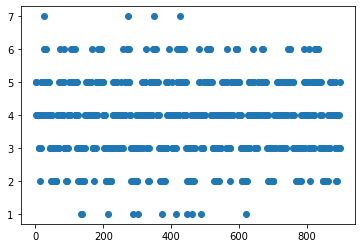

In [5]:
y = np.zeros(len(x))
at = np.zeros(len(x))
for i in range(1,len(x)):
    at[i] = g(at[i-1])
#
for i in range(len(x)):
    y[i] = f(x[i])
y = y.ravel()
dy = random.randint(1, 2) * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y -= min(y)
for i in range(len(x)):
    y[i] = int(y[i])
y += 1
plt.plot(x, y, 'o')
plt.show()

# Burst time prediction algorithm
# test with different ones

<AxesSubplot:xlabel='process', ylabel='arrival time'>

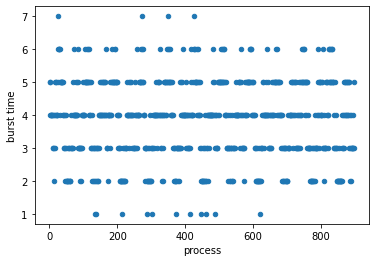

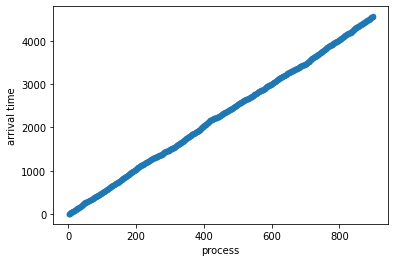

In [6]:
# build train / test sets
df_bt = pd.DataFrame({'process':x, 'burst time':y, 'arrival time':at})
df_bt.plot('process', 'burst time', kind='scatter')
df_bt.plot('process', 'arrival time', kind='scatter')

In [7]:
X = df_bt.drop('burst time', axis=1)
bt_aver = df_bt['burst time'].mean()
yc = df_bt['burst time']
y = df_bt['burst time'] - bt_aver
y.head()
X.head()

,process,arrival time
0,1,0.0
1,2,0.0
2,3,2.0
3,4,7.0
4,5,16.0


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=32)
X_train.head()
y_train.head()

605    0.176863
725    1.176863
624   -0.823137
453   -0.823137
845    0.176863
Name: burst time, dtype: float64

In [9]:
print(len(X_train), len(X_test), len(X_train)+len(X_test))

629 270 899


# Use KK neighbors classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=25)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, yc, test_size=0.30, random_state=32)
# train the model
knn.fit(Xc_train, yc_train)
s=knn.score(Xc_test, yc_test)
print(s)
# predict response for test
y_pred = knn.predict(Xc_test)

0.3851851851851852


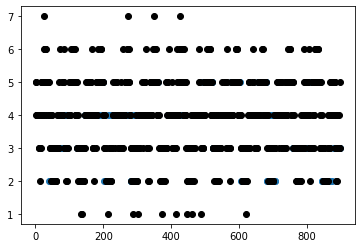

In [11]:
# plot model
plt.plot(x, yc, 'o', color='k')
plt.scatter(X_test['process'], y_pred)
plt.show()

# build logistic regression model

In [12]:
from sklearn.linear_model import LinearRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#scaler = StandardScaler()
#scalerY = StandardScaler().fit(np.asarray(y_train).reshape(-1,1))
#pipe = make_pipeline(scaler, LogisticRegression())
#pipe.fit(X_train, scalerY.transform(np.asarray(y_train).reshape(-1,1)))
#pipe.fit(X_train, y_train)
#s = pipe.score(X_train, y_train)
#print(s)
#ypred = scalerY.inverse_transform(pipe.predict(X_test))
#
logmodel = LinearRegression()
logmodel.fit(X_train, y_train)
y_pred = logmodel.predict(X_test)

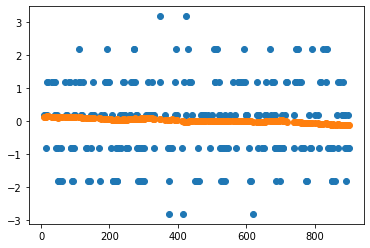

In [13]:
plt.scatter(X_test['process'], y_test)
plt.scatter(X_test['process'], y_pred)
plt.show()

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X_test, return_std=True)

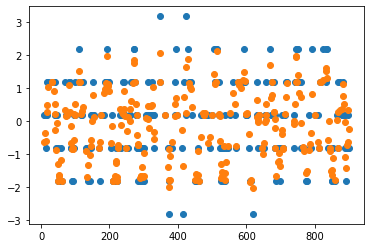

0.8377130441368965


In [15]:
plt.scatter(X_test['process'], y_test)
plt.scatter(X_test['process'], y_pred)
plt.show()
s = gp.score(X_test, y_test)
print(s)

# set approximate learning function

In [16]:
def burst_pred(t_n, tau_n, alpha):
    tau = alpha * t_n + (1 - alpha) * tau_n
    return int(tau)

In [17]:
bt_pred_approx = np.zeros(len(y), dtype=int)
bt_pred_approx[0] = yc[0]   # set to process 1 burst time
for i in range(1, len(y)):
    tau_n = bt_pred_approx[i-1]
    t_n = yc[i-1]
    bt_pred_approx[i] = burst_pred(t_n, tau_n, 0.5)

In [18]:
# set gauss process predicted value
bt_pred = np.zeros(len(y), dtype=int)
y_pred, sigma = gp.predict(X, return_std=True)
for i in range(len(y)):
    r = y_pred[i] + bt_aver
    bt_pred[i] = int(r)

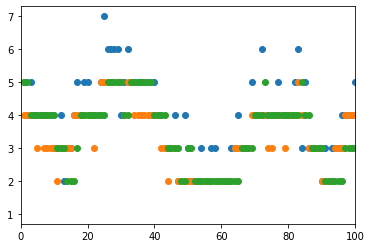

In [19]:
plt.xlim([0,100])
plt.scatter(X['process'], yc)
plt.scatter(X['process'], bt_pred)
plt.scatter(X['process'], bt_pred_approx)
plt.show()

# implement SJF scheduler

In [20]:
def SJF_scheduler(ye, yp):
    # create waiting queue with process id
    # use ye - yp to select burst times for different jobs - exact - approx
    waiting_q = []
    bt_exact = []
    bt_approx = []
    wt_list = []
    tat_list = []
    at = list(df_bt['arrival time'])   # arrival time list
    #print(at[:20])
    #print(ye[:20])
    for i in range(len(at)):
        t = at[i]
        if t == 0:
            waiting_q.append(x[i])
            bt_exact.append(ye[i])
            bt_approx.append(yp[i])
    #
    t = 0
    jobr_id = 0
    run_time = 0
    # start cycle
    while(len(waiting_q) > 0 or len(wt_list) < len(x)):
        # if no job is running find the job to run according
        # to SJF scheduling
        #print(t, len(waiting_q), len(burst_times))
        # update time
        t = t + 1
        if run_time > 0:
            if run_time == me:
                jobr_id = 0
            else:
                run_time = run_time + 1   # update run time
        # check if job_id 0
        if jobr_id == 0:
            if len(bt_approx) > 0:
                mp = min(bt_approx)
                idx = bt_approx.index(mp)
                me = bt_exact[idx]
                jobr_id = waiting_q[idx]
                print("job running: %d" % jobr_id)
                wt_list.append(t-1-at[jobr_id-1])
                tat_list.append(t-1+me-at[jobr_id-1])
                run_time = 1
                # pop job from waiting list
                waiting_q.remove(jobr_id)
                mp = bt_approx.pop(idx)
                me = bt_exact.pop(idx)
        # add job to queue if needed
        for j in range(len(at)):
            t0 = at[j]
            if t == t0:
                waiting_q.append(x[j])
                bt_exact.append(ye[j])
                bt_approx.append(yp[j])
            elif t0 > t:
                break
    return wt_list, tat_list

In [21]:
wt0, tat0 = SJF_scheduler(yc, yc)
print(sum(yc))
y = np.zeros(len(wt0))
for i in range(len(y)):
    y[i] = tat0[i] - wt0[i]
print(sum(y))

job running: 2
job running: 1
job running: 4
job running: 3
job running: 5
job running: 6
job running: 7
job running: 10
job running: 11
job running: 8
job running: 9
job running: 12
job running: 13
job running: 14
job running: 15
job running: 16
job running: 18
job running: 17
job running: 19
job running: 20
job running: 21
job running: 22
job running: 23
job running: 24
job running: 25
job running: 26
job running: 27
job running: 30
job running: 31
job running: 28
job running: 29
job running: 33
job running: 34
job running: 35
job running: 36
job running: 32
job running: 39
job running: 37
job running: 38
job running: 41
job running: 40
job running: 42
job running: 43
job running: 44
job running: 45
job running: 46
job running: 47
job running: 48
job running: 49
job running: 50
job running: 51
job running: 52
job running: 53
job running: 54
job running: 55
job running: 56
job running: 57
job running: 59
job running: 58
job running: 60
job running: 61
job running: 62
job running: 63
j

job running: 614
job running: 615
job running: 616
job running: 617
job running: 618
job running: 619
job running: 620
job running: 621
job running: 622
job running: 623
job running: 624
job running: 625
job running: 626
job running: 627
job running: 628
job running: 629
job running: 630
job running: 631
job running: 633
job running: 632
job running: 634
job running: 635
job running: 636
job running: 637
job running: 638
job running: 639
job running: 641
job running: 643
job running: 644
job running: 640
job running: 645
job running: 642
job running: 646
job running: 647
job running: 648
job running: 649
job running: 650
job running: 651
job running: 652
job running: 653
job running: 654
job running: 655
job running: 656
job running: 657
job running: 658
job running: 659
job running: 661
job running: 662
job running: 660
job running: 663
job running: 664
job running: 665
job running: 666
job running: 667
job running: 668
job running: 672
job running: 673
job running: 671
job running: 6

# repeat procedure for approximate predictor

In [22]:
wt1, tat1 = SJF_scheduler(yc, bt_pred_approx)

job running: 1
job running: 3
job running: 4
job running: 2
job running: 5
job running: 6
job running: 7
job running: 8
job running: 11
job running: 9
job running: 10
job running: 12
job running: 13
job running: 14
job running: 15
job running: 16
job running: 17
job running: 18
job running: 19
job running: 20
job running: 21
job running: 22
job running: 23
job running: 24
job running: 25
job running: 26
job running: 27
job running: 28
job running: 31
job running: 32
job running: 29
job running: 30
job running: 33
job running: 34
job running: 35
job running: 36
job running: 37
job running: 38
job running: 40
job running: 41
job running: 39
job running: 42
job running: 43
job running: 44
job running: 45
job running: 46
job running: 47
job running: 48
job running: 49
job running: 50
job running: 52
job running: 51
job running: 53
job running: 54
job running: 55
job running: 56
job running: 57
job running: 58
job running: 59
job running: 60
job running: 61
job running: 62
job running: 63
j

job running: 708
job running: 709
job running: 710
job running: 711
job running: 712
job running: 713
job running: 714
job running: 715
job running: 716
job running: 717
job running: 718
job running: 719
job running: 720
job running: 721
job running: 722
job running: 723
job running: 724
job running: 725
job running: 726
job running: 727
job running: 728
job running: 729
job running: 730
job running: 731
job running: 732
job running: 733
job running: 734
job running: 735
job running: 736
job running: 737
job running: 738
job running: 739
job running: 740
job running: 741
job running: 742
job running: 743
job running: 744
job running: 745
job running: 746
job running: 747
job running: 748
job running: 749
job running: 750
job running: 751
job running: 752
job running: 753
job running: 754
job running: 755
job running: 756
job running: 757
job running: 758
job running: 759
job running: 760
job running: 761
job running: 762
job running: 763
job running: 764
job running: 765
job running: 7

In [23]:
wt2, tat2 = SJF_scheduler(yc, bt_pred)

job running: 1
job running: 2
job running: 3
job running: 4
job running: 5
job running: 6
job running: 7
job running: 8
job running: 11
job running: 9
job running: 10
job running: 12
job running: 13
job running: 14
job running: 15
job running: 16
job running: 17
job running: 18
job running: 19
job running: 20
job running: 21
job running: 22
job running: 23
job running: 24
job running: 25
job running: 26
job running: 27
job running: 28
job running: 31
job running: 29
job running: 30
job running: 32
job running: 34
job running: 35
job running: 36
job running: 37
job running: 38
job running: 39
job running: 40
job running: 41
job running: 33
job running: 42
job running: 43
job running: 44
job running: 45
job running: 46
job running: 47
job running: 48
job running: 49
job running: 50
job running: 51
job running: 52
job running: 53
job running: 54
job running: 55
job running: 56
job running: 57
job running: 58
job running: 59
job running: 60
job running: 61
job running: 62
job running: 63
j

job running: 643
job running: 644
job running: 645
job running: 646
job running: 647
job running: 648
job running: 649
job running: 650
job running: 651
job running: 652
job running: 653
job running: 654
job running: 655
job running: 656
job running: 657
job running: 658
job running: 659
job running: 660
job running: 661
job running: 662
job running: 663
job running: 664
job running: 665
job running: 666
job running: 667
job running: 668
job running: 671
job running: 672
job running: 673
job running: 674
job running: 677
job running: 678
job running: 669
job running: 679
job running: 680
job running: 681
job running: 682
job running: 683
job running: 684
job running: 670
job running: 685
job running: 675
job running: 686
job running: 687
job running: 689
job running: 688
job running: 690
job running: 676
job running: 691
job running: 692
job running: 693
job running: 694
job running: 695
job running: 696
job running: 697
job running: 698
job running: 701
job running: 699
job running: 7

# average waiting times

In [24]:
wt_aver0 = sum(wt0) / len(wt0)
wt_aver1 = sum(wt1) / len(wt1)
wt_aver2 = sum(wt2) / len(wt2)
print("exact scheduler average waiting time: %.7f" % wt_aver0)
print("simple approx. scheduler average waiting time: %.7f" % wt_aver1)
print("simple ML scheduler average waiting time: %.7f" % wt_aver2)

exact scheduler average waiting time: 3.3515017
simple approx. scheduler average waiting time: 3.7797553
simple ML scheduler average waiting time: 3.6451613


In [25]:
tat_aver0 = sum(tat0) / len(tat0)
tat_aver1 = sum(tat1) / len(tat1)
tat_aver2 = sum(tat2) / len(tat2)
print("exact scheduler average turn around time: %.7f" % tat_aver0)
print("simple approx. scheduler average turn around time: %.7f" % tat_aver1)
print("simple ML scheduler average turn around time: %.7f" % tat_aver2)

exact scheduler average turn around time: 7.1746385
simple approx. scheduler average turn around time: 7.6028921
simple ML scheduler average turn around time: 7.4682981


# preemptive algorithm

In [61]:
def SJF_scheduler_preemptive(ye, yp):
    # create waiting queue with process id
    # use ye - yp to select burst times for different jobs - exact - approx
    waiting_q = []
    bt_exact = []
    bt_approx = []
    time_left = []
    wt_list = []
    tat_list = []
    at = list(df_bt['arrival time'])            # arrival time list
    started_run = np.zeros(len(at), dtype=int)  # started run jobs list
    for i in range(len(at)):
        t = at[i]
        if t == 0:
            waiting_q.append(x[i])
            bt_exact.append(ye[i])
            bt_approx.append(yp[i])
            time_left.append(yp[i])
    #
    t = 0
    idx = 0
    # start cycle iteration
    while(len(waiting_q) > 0 or len(tat_list) < len(x)):
        # if no job is running find the job to run according
        # to SJF scheduling
        #print(t, len(waiting_q), len(burst_times))
        # update time
        t = t + 1
        # do not check if job_id 0 -> the algorithm is preemptive
        # we need to check every time now
        if len(time_left) > 0:
            mp = min(time_left)
            idx = time_left.index(mp)
            jobr_id = waiting_q[idx]
            print("job running: %d" % jobr_id)
            #print(jobr_id, started_run[jobr_id-1])
            if started_run[jobr_id-1] == 0:
                wttime = t - 1 - at[jobr_id-1]
                wt_list.append(wttime)
                time_left[idx] = bt_exact[idx] - 1
                started_run[jobr_id-1] = 1
            else:
                if mp == 0:
                    tatime = t - 1 - at[jobr_id-1]
                    tat_list.append(tatime)
                    # pop job from waiting list : only in this case
                    waiting_q.remove(jobr_id)
                    mp1 = bt_approx.pop(idx)
                    mp2 = time_left.pop(idx)
                    me  = bt_exact.pop(idx)
                else:
                    time_left[idx] = time_left[idx] - 1   # update run time
        # add job to queue if needed
        for j in range(len(at)):
            t0 = at[j]
            if t == t0:
                waiting_q.append(x[j])
                bt_exact.append(ye[j])
                bt_approx.append(yp[j])
                time_left.append(yp[j])
            elif t0 > t:
                break
    return wt_list, tat_list

In [62]:
wt0, tat0 = SJF_scheduler_preemptive(yc, yc)
print(sum(yc))
y = np.zeros(len(wt0))
for i in range(len(y)):
    y[i] = tat0[i] - wt0[i]
print(sum(y))

job running: 1
job running: 2
job running: 2
job running: 2
job running: 2
job running: 2
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 7
job running: 7
job running: 7
job running: 7
job running: 7
job running: 7
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 9
job running: 9
job running: 9
job running: 9
job running: 9
job running: 9
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
jo

job running: 283
job running: 283
job running: 283
job running: 283
job running: 283
job running: 283
job running: 285
job running: 285
job running: 285
job running: 285
job running: 285
job running: 285
job running: 285
job running: 286
job running: 286
job running: 286
job running: 286
job running: 286
job running: 286
job running: 286
job running: 287
job running: 287
job running: 287
job running: 287
job running: 287
job running: 287
job running: 288
job running: 288
job running: 288
job running: 288
job running: 288
job running: 289
job running: 289
job running: 289
job running: 289
job running: 289
job running: 289
job running: 291
job running: 291
job running: 291
job running: 291
job running: 291
job running: 290
job running: 290
job running: 290
job running: 290
job running: 290
job running: 290
job running: 294
job running: 294
job running: 294
job running: 294
job running: 294
job running: 292
job running: 292
job running: 292
job running: 292
job running: 292
job running: 2

job running: 523
job running: 523
job running: 523
job running: 521
job running: 521
job running: 521
job running: 521
job running: 521
job running: 521
job running: 521
job running: 524
job running: 524
job running: 524
job running: 524
job running: 524
job running: 525
job running: 525
job running: 525
job running: 525
job running: 525
job running: 525
job running: 527
job running: 527
job running: 527
job running: 527
job running: 527
job running: 527
job running: 528
job running: 529
job running: 529
job running: 529
job running: 529
job running: 528
job running: 528
job running: 528
job running: 528
job running: 528
job running: 531
job running: 531
job running: 531
job running: 531
job running: 531
job running: 530
job running: 530
job running: 530
job running: 530
job running: 530
job running: 530
job running: 526
job running: 526
job running: 526
job running: 526
job running: 526
job running: 526
job running: 526
job running: 535
job running: 535
job running: 535
job running: 5

job running: 720
job running: 720
job running: 720
job running: 720
job running: 720
job running: 720
job running: 721
job running: 721
job running: 721
job running: 721
job running: 479
job running: 722
job running: 722
job running: 722
job running: 722
job running: 722
job running: 479
job running: 479
job running: 479
job running: 479
job running: 479
job running: 479
job running: 479
job running: 480
job running: 480
job running: 480
job running: 480
job running: 480
job running: 480
job running: 480
job running: 480
job running: 725
job running: 725
job running: 725
job running: 725
job running: 725
job running: 725
job running: 725
job running: 726
job running: 726
job running: 726
job running: 726
job running: 726
job running: 726
job running: 726
job running: 728
job running: 728
job running: 728
job running: 728
job running: 728
job running: 728
job running: 727
job running: 727
job running: 730
job running: 730
job running: 730
job running: 730
job running: 727
job running: 7

job running: 799
job running: 801
job running: 801
job running: 801
job running: 801
job running: 801
job running: 801
job running: 801
job running: 801
job running: 802
job running: 802
job running: 802
job running: 802
job running: 802
job running: 802
job running: 802
job running: 802
job running: 805
job running: 805
job running: 805
job running: 805
job running: 805
job running: 805
job running: 805
job running: 805
job running: 806
job running: 806
job running: 806
job running: 806
job running: 806
job running: 806
job running: 806
job running: 806
job running: 808
job running: 808
job running: 808
job running: 808
job running: 808
job running: 808
job running: 808
job running: 808
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 816
job running: 8

job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 248
job running: 248
job running: 248
job running: 248
job running: 248
job running: 248
job running: 248
job running: 248
job running: 248
job running: 259
job running: 259
job running: 259
job running: 259
job running: 259
job running: 259
job running: 259
job running: 259
job running: 259
job running: 261
job running: 261
job running: 261
job running: 261
job running: 261
job running: 261
job running: 261
job running: 261
job running: 261
job running: 266
job running: 266
job running: 266
job running: 266
job running: 266
job running: 266
job running: 266
job running: 266
job running: 266
job running: 270
job running: 270
job running: 270
job running: 270
job running: 270
job running: 270
job running: 270
job running: 270
job running: 270
job running: 275
job running: 275
job running: 275
job running: 275
job running: 2

job running: 37
job running: 37
job running: 37
job running: 37
job running: 37
job running: 37
job running: 37
job running: 37
job running: 96
job running: 96
job running: 96
job running: 96
job running: 96
job running: 96
job running: 96
job running: 96
job running: 96
job running: 96
job running: 106
job running: 106
job running: 106
job running: 106
job running: 106
job running: 106
job running: 106
job running: 106
job running: 106
job running: 106
job running: 111
job running: 111
job running: 111
job running: 111
job running: 111
job running: 111
job running: 111
job running: 111
job running: 111
job running: 111
job running: 112
job running: 112
job running: 112
job running: 112
job running: 112
job running: 112
job running: 112
job running: 112
job running: 112
job running: 112
job running: 113
job running: 113
job running: 113
job running: 113
job running: 113
job running: 113
job running: 113
job running: 113
job running: 113
job running: 113
job running: 161
job running: 16

In [63]:
wt1, tat1 = SJF_scheduler_preemptive(yc, bt_pred_approx)

job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 2
job running: 2
job running: 2
job running: 2
job running: 2
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 9
job running: 9
job running: 9
job running: 9
job running: 9
job running: 9
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 6
job running: 6
job running: 6
job running: 6
job running: 6
job running: 6
jo

job running: 173
job running: 173
job running: 173
job running: 173
job running: 173
job running: 173
job running: 174
job running: 174
job running: 174
job running: 174
job running: 174
job running: 174
job running: 174
job running: 175
job running: 175
job running: 175
job running: 175
job running: 175
job running: 177
job running: 177
job running: 177
job running: 177
job running: 177
job running: 177
job running: 177
job running: 178
job running: 178
job running: 178
job running: 178
job running: 178
job running: 178
job running: 178
job running: 178
job running: 179
job running: 179
job running: 179
job running: 179
job running: 179
job running: 179
job running: 179
job running: 179
job running: 180
job running: 180
job running: 180
job running: 180
job running: 180
job running: 180
job running: 181
job running: 181
job running: 181
job running: 181
job running: 181
job running: 181
job running: 181
job running: 182
job running: 182
job running: 182
job running: 182
job running: 1

job running: 304
job running: 294
job running: 294
job running: 294
job running: 294
job running: 294
job running: 295
job running: 295
job running: 295
job running: 295
job running: 295
job running: 295
job running: 296
job running: 296
job running: 296
job running: 296
job running: 296
job running: 296
job running: 297
job running: 297
job running: 297
job running: 297
job running: 297
job running: 297
job running: 298
job running: 298
job running: 298
job running: 298
job running: 298
job running: 298
job running: 299
job running: 299
job running: 299
job running: 299
job running: 299
job running: 299
job running: 300
job running: 300
job running: 300
job running: 300
job running: 300
job running: 300
job running: 301
job running: 301
job running: 301
job running: 301
job running: 301
job running: 304
job running: 304
job running: 304
job running: 304
job running: 304
job running: 304
job running: 305
job running: 305
job running: 305
job running: 305
job running: 305
job running: 3

job running: 487
job running: 487
job running: 487
job running: 487
job running: 488
job running: 488
job running: 488
job running: 488
job running: 488
job running: 488
job running: 488
job running: 489
job running: 489
job running: 489
job running: 489
job running: 489
job running: 489
job running: 491
job running: 496
job running: 496
job running: 496
job running: 496
job running: 496
job running: 496
job running: 496
job running: 497
job running: 497
job running: 497
job running: 497
job running: 497
job running: 497
job running: 497
job running: 497
job running: 498
job running: 498
job running: 498
job running: 498
job running: 498
job running: 498
job running: 498
job running: 499
job running: 499
job running: 499
job running: 499
job running: 499
job running: 499
job running: 499
job running: 499
job running: 500
job running: 500
job running: 500
job running: 500
job running: 500
job running: 500
job running: 500
job running: 501
job running: 501
job running: 501
job running: 5

job running: 657
job running: 657
job running: 657
job running: 658
job running: 658
job running: 658
job running: 658
job running: 658
job running: 658
job running: 659
job running: 663
job running: 637
job running: 637
job running: 637
job running: 637
job running: 637
job running: 637
job running: 637
job running: 638
job running: 638
job running: 638
job running: 638
job running: 638
job running: 638
job running: 638
job running: 638
job running: 639
job running: 639
job running: 639
job running: 639
job running: 639
job running: 639
job running: 639
job running: 640
job running: 640
job running: 640
job running: 640
job running: 640
job running: 640
job running: 640
job running: 641
job running: 641
job running: 641
job running: 641
job running: 641
job running: 641
job running: 641
job running: 641
job running: 642
job running: 642
job running: 642
job running: 642
job running: 642
job running: 642
job running: 642
job running: 642
job running: 643
job running: 643
job running: 6

job running: 809
job running: 809
job running: 809
job running: 809
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 811
job running: 811
job running: 811
job running: 811
job running: 811
job running: 811
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 815
job running: 815
job running: 815
job running: 815
job running: 815
job running: 815
job running: 815
job running: 816
job running: 816
job running: 816
job running: 816
job running: 816
job running: 816
job running: 816
job running: 816
job running: 817
job running: 817
job running: 817
job running: 817
job running: 817
job running: 817
job running: 817
job running: 818
job running: 818
job running: 818
job running: 818
job running: 818
job running: 818
job running: 819
job running: 819
job running: 819
job running: 819
job running: 819
job running: 8

job running: 351
job running: 351
job running: 352
job running: 354
job running: 354
job running: 354
job running: 354
job running: 354
job running: 354
job running: 354
job running: 354
job running: 354
job running: 355
job running: 355
job running: 355
job running: 355
job running: 355
job running: 355
job running: 355
job running: 357
job running: 357
job running: 357
job running: 357
job running: 357
job running: 357
job running: 357
job running: 357
job running: 358
job running: 358
job running: 358
job running: 358
job running: 358
job running: 358
job running: 358
job running: 358
job running: 359
job running: 359
job running: 359
job running: 359
job running: 359
job running: 359
job running: 359
job running: 393
job running: 393
job running: 393
job running: 393
job running: 393
job running: 393
job running: 393
job running: 393
job running: 397
job running: 397
job running: 397
job running: 397
job running: 397
job running: 397
job running: 397
job running: 397
job running: 3

job running: 665
job running: 665
job running: 665
job running: 665
job running: 665
job running: 665
job running: 666
job running: 666
job running: 666
job running: 666
job running: 666
job running: 666
job running: 666
job running: 666
job running: 667
job running: 667
job running: 667
job running: 667
job running: 667
job running: 667
job running: 667
job running: 667
job running: 668
job running: 668
job running: 668
job running: 668
job running: 668
job running: 668
job running: 668
job running: 668
job running: 669
job running: 671
job running: 671
job running: 671
job running: 671
job running: 671
job running: 671
job running: 671
job running: 672
job running: 672
job running: 672
job running: 672
job running: 672
job running: 672
job running: 672
job running: 672
job running: 673
job running: 673
job running: 673
job running: 673
job running: 673
job running: 673
job running: 673
job running: 673
job running: 674
job running: 674
job running: 674
job running: 674
job running: 6

job running: 28
job running: 28
job running: 29
job running: 29
job running: 29
job running: 29
job running: 29
job running: 29
job running: 29
job running: 29
job running: 29
job running: 30
job running: 30
job running: 30
job running: 30
job running: 30
job running: 30
job running: 30
job running: 30
job running: 30
job running: 31
job running: 31
job running: 31
job running: 31
job running: 31
job running: 31
job running: 31
job running: 31
job running: 32
job running: 32
job running: 32
job running: 32
job running: 32
job running: 32
job running: 32
job running: 32
job running: 32
job running: 33
job running: 33
job running: 33
job running: 33
job running: 33
job running: 33
job running: 33
job running: 33
job running: 33
job running: 33
job running: 34
job running: 34
job running: 34
job running: 34
job running: 34
job running: 34
job running: 34
job running: 34
job running: 34
job running: 34
job running: 35
job running: 39
job running: 39
job running: 39
job running: 39
job runn

job running: 38
job running: 38
job running: 38
job running: 38
job running: 114
job running: 114
job running: 114
job running: 114
job running: 114
job running: 114
job running: 114
job running: 114
job running: 114
job running: 114
job running: 115
job running: 115
job running: 115
job running: 115
job running: 115
job running: 115
job running: 115
job running: 115
job running: 115
job running: 198
job running: 198
job running: 198
job running: 198
job running: 198
job running: 198
job running: 198
job running: 198
job running: 198
job running: 198
job running: 224
job running: 224
job running: 224
job running: 224
job running: 224
job running: 224
job running: 224
job running: 224
job running: 224
job running: 224
job running: 265
job running: 265
job running: 265
job running: 265
job running: 265
job running: 265
job running: 265
job running: 265
job running: 265
job running: 265
job running: 267
job running: 267
job running: 267
job running: 267
job running: 267
job running: 267
j

In [64]:
wt2, tat2 = SJF_scheduler_preemptive(yc, bt_pred)

job running: 1
job running: 2
job running: 2
job running: 2
job running: 2
job running: 2
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 1
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 3
job running: 5
job running: 6
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 4
job running: 7
job running: 7
job running: 7
job running: 7
job running: 7
job running: 7
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 8
job running: 5
job running: 9
job running: 9
job running: 9
job running: 9
job running: 9
job running: 9
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 5
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job running: 10
job

job running: 140
job running: 140
job running: 141
job running: 141
job running: 141
job running: 141
job running: 141
job running: 141
job running: 142
job running: 142
job running: 142
job running: 142
job running: 143
job running: 143
job running: 143
job running: 143
job running: 143
job running: 144
job running: 144
job running: 144
job running: 144
job running: 144
job running: 144
job running: 145
job running: 145
job running: 145
job running: 145
job running: 145
job running: 145
job running: 146
job running: 146
job running: 146
job running: 146
job running: 146
job running: 146
job running: 147
job running: 147
job running: 147
job running: 147
job running: 147
job running: 147
job running: 147
job running: 128
job running: 128
job running: 128
job running: 128
job running: 128
job running: 128
job running: 128
job running: 138
job running: 138
job running: 138
job running: 138
job running: 138
job running: 138
job running: 138
job running: 148
job running: 148
job running: 1

job running: 246
job running: 246
job running: 246
job running: 246
job running: 246
job running: 247
job running: 247
job running: 247
job running: 247
job running: 247
job running: 247
job running: 247
job running: 248
job running: 251
job running: 251
job running: 251
job running: 251
job running: 251
job running: 251
job running: 251
job running: 252
job running: 252
job running: 252
job running: 252
job running: 252
job running: 252
job running: 252
job running: 252
job running: 253
job running: 253
job running: 253
job running: 253
job running: 253
job running: 253
job running: 253
job running: 253
job running: 254
job running: 254
job running: 254
job running: 254
job running: 254
job running: 254
job running: 254
job running: 254
job running: 255
job running: 255
job running: 255
job running: 255
job running: 255
job running: 255
job running: 255
job running: 256
job running: 256
job running: 256
job running: 256
job running: 256
job running: 256
job running: 256
job running: 2

job running: 394
job running: 394
job running: 394
job running: 394
job running: 394
job running: 406
job running: 406
job running: 406
job running: 406
job running: 406
job running: 406
job running: 406
job running: 407
job running: 407
job running: 407
job running: 407
job running: 407
job running: 407
job running: 408
job running: 408
job running: 408
job running: 408
job running: 408
job running: 408
job running: 409
job running: 409
job running: 409
job running: 409
job running: 409
job running: 409
job running: 410
job running: 410
job running: 410
job running: 410
job running: 410
job running: 410
job running: 410
job running: 411
job running: 411
job running: 411
job running: 411
job running: 411
job running: 412
job running: 412
job running: 412
job running: 412
job running: 412
job running: 412
job running: 412
job running: 413
job running: 413
job running: 413
job running: 413
job running: 413
job running: 413
job running: 414
job running: 414
job running: 414
job running: 4

job running: 568
job running: 568
job running: 568
job running: 569
job running: 569
job running: 569
job running: 569
job running: 569
job running: 569
job running: 569
job running: 570
job running: 570
job running: 570
job running: 570
job running: 570
job running: 570
job running: 571
job running: 571
job running: 571
job running: 571
job running: 571
job running: 571
job running: 571
job running: 572
job running: 572
job running: 572
job running: 572
job running: 572
job running: 572
job running: 572
job running: 573
job running: 573
job running: 573
job running: 573
job running: 573
job running: 573
job running: 573
job running: 554
job running: 554
job running: 554
job running: 554
job running: 554
job running: 554
job running: 554
job running: 555
job running: 555
job running: 555
job running: 555
job running: 555
job running: 555
job running: 555
job running: 555
job running: 556
job running: 556
job running: 556
job running: 556
job running: 556
job running: 556
job running: 5

job running: 682
job running: 682
job running: 682
job running: 682
job running: 682
job running: 683
job running: 683
job running: 683
job running: 683
job running: 683
job running: 687
job running: 687
job running: 687
job running: 687
job running: 687
job running: 687
job running: 687
job running: 699
job running: 699
job running: 699
job running: 699
job running: 699
job running: 699
job running: 699
job running: 701
job running: 701
job running: 701
job running: 701
job running: 701
job running: 701
job running: 701
job running: 706
job running: 706
job running: 706
job running: 706
job running: 706
job running: 706
job running: 706
job running: 708
job running: 708
job running: 708
job running: 708
job running: 708
job running: 709
job running: 709
job running: 709
job running: 709
job running: 709
job running: 709
job running: 709
job running: 709
job running: 731
job running: 731
job running: 731
job running: 731
job running: 731
job running: 731
job running: 731
job running: 7

job running: 809
job running: 809
job running: 809
job running: 809
job running: 809
job running: 809
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 810
job running: 811
job running: 811
job running: 811
job running: 811
job running: 811
job running: 811
job running: 812
job running: 812
job running: 812
job running: 812
job running: 812
job running: 812
job running: 812
job running: 813
job running: 813
job running: 813
job running: 813
job running: 813
job running: 813
job running: 813
job running: 814
job running: 844
job running: 845
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 814
job running: 846
job running: 815
job running: 815
job running: 815
job running: 815
job running: 815
job running: 815
job running: 815
job running: 847
job running: 847
job running: 847
job running: 847
job running: 847
job running: 847
job running: 8

job running: 238
job running: 238
job running: 238
job running: 238
job running: 239
job running: 239
job running: 239
job running: 239
job running: 239
job running: 239
job running: 239
job running: 239
job running: 239
job running: 240
job running: 240
job running: 240
job running: 240
job running: 240
job running: 240
job running: 240
job running: 240
job running: 240
job running: 241
job running: 241
job running: 241
job running: 241
job running: 241
job running: 241
job running: 241
job running: 241
job running: 241
job running: 242
job running: 242
job running: 242
job running: 242
job running: 242
job running: 242
job running: 242
job running: 242
job running: 243
job running: 243
job running: 243
job running: 243
job running: 243
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 245
job running: 248
job running: 248
job running: 248
job running: 248
job running: 248
job running: 248
job running: 2

job running: 557
job running: 557
job running: 557
job running: 557
job running: 557
job running: 557
job running: 557
job running: 561
job running: 562
job running: 562
job running: 562
job running: 562
job running: 562
job running: 580
job running: 580
job running: 580
job running: 580
job running: 580
job running: 580
job running: 580
job running: 580
job running: 580
job running: 581
job running: 581
job running: 581
job running: 581
job running: 581
job running: 581
job running: 581
job running: 581
job running: 582
job running: 582
job running: 582
job running: 582
job running: 582
job running: 582
job running: 582
job running: 582
job running: 583
job running: 583
job running: 583
job running: 583
job running: 583
job running: 583
job running: 583
job running: 583
job running: 591
job running: 591
job running: 591
job running: 591
job running: 591
job running: 591
job running: 591
job running: 591
job running: 591
job running: 592
job running: 593
job running: 593
job running: 5

job running: 502
job running: 511
job running: 511
job running: 511
job running: 511
job running: 511
job running: 511
job running: 511
job running: 511
job running: 511
job running: 512
job running: 512
job running: 512
job running: 512
job running: 512
job running: 512
job running: 512
job running: 512
job running: 512
job running: 513
job running: 513
job running: 513
job running: 513
job running: 513
job running: 513
job running: 513
job running: 513
job running: 513
job running: 516
job running: 516
job running: 516
job running: 516
job running: 516
job running: 516
job running: 516
job running: 516
job running: 516
job running: 592
job running: 592
job running: 592
job running: 592
job running: 592
job running: 592
job running: 592
job running: 592
job running: 592
job running: 594
job running: 594
job running: 594
job running: 594
job running: 594
job running: 594
job running: 594
job running: 594
job running: 594
job running: 595
job running: 595
job running: 595
job running: 5

# Average waiting times

In [65]:
wt_aver0 = sum(wt0) / len(wt0)
#print(wt0)
wt_aver1 = sum(wt1) / len(wt1)
wt_aver2 = sum(wt2) / len(wt2)
print("exact scheduler average waiting time: %.7f" % wt_aver0)
print("simple approx. scheduler average waiting time: %.7f" % wt_aver1)
print("simple ML scheduler average waiting time: %.7f" % wt_aver2)

exact scheduler average waiting time: 866.5572859
simple approx. scheduler average waiting time: 727.9087875
simple ML scheduler average waiting time: 744.4994438


In [66]:
tat_aver0 = sum(tat0) / len(tat0)
tat_aver1 = sum(tat1) / len(tat1)
tat_aver2 = sum(tat2) / len(tat2)
print("exact scheduler average turn around time: %.7f" % tat_aver0)
print("simple approx. scheduler average turn around time: %.7f" % tat_aver1)
print("simple ML scheduler average turn around time: %.7f" % tat_aver2)

exact scheduler average turn around time: 872.9655172
simple approx. scheduler average turn around time: 946.7141268
simple ML scheduler average turn around time: 928.3136819
